In [21]:
# import the necessary data
import datetime
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import io
from alpha_vantage.timeseries import TimeSeries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

%matplotlib inline

In [22]:
import warnings
warnings.filterwarnings("ignore")

reference: 
* https://facebook.github.io/prophet/docs/trend_changepoints.html
* http://pandas.pydata.org/pandas-docs/version/0.15.0/visualization.html#visualization-autocorrelation
* https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
* https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
* https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a
* https://www.alphavantage.co/documentation/

In [26]:
class shares():
    
    '''
    this is the main class 
    1. getting the share price data
    2. make df willl call handle_dates for get the dates ranges
    '''
    # Initialization requires a ticker symbol
    def __init__(self, ticker):
        
        # Enforce capitalization
        ticker = ticker.upper()

        # Symbol is used for labeling plots
        self.symbol = ticker

        #Enter Alpha Vantage API Key
        API_KEY='EM9ML5Z8462GSH50'

        #Based URL with function = 'TIME_SERIES_DAILY'
        ALPHA_URL = 'https://www.alphavantage.co/query?outputsize=full&'
        QUERY_URL = ALPHA_URL+"function=TIME_SERIES_DAILY_ADJUSTED&apikey={KEY}&symbol={SYMBOL}"


        # Getting share price from Alph Vantage
        import json
        import urllib.request


        # open the URL with the stock data of interest
        with urllib.request.urlopen(QUERY_URL.format(KEY=API_KEY, SYMBOL=self.symbol)) as req:
            data = req.read().decode("UTF-8")

        # getting json data back
        json_data = json.loads(data)

        # to confirm there are data returned
        if len(json_data) < 2:
            print ('Unable to get the stock data for ', ticker)
            return None

        # getting keys
        key_dat = list(json_data.keys())[1]

        # getting date/time series
        ts = json_data[key_dat]

        #print ("time series", ts)

        # create datafrome from ts
        stock = pd.DataFrame(ts).T

        # now split columns to get values
        stock = stock.rename(columns={
            "1. open": "Adj. Open",
            "2. high": "High",
            "3. low": "Low",
            "4. close": "Close",
            "5. adjusted close": "Adj. Close",
            "6. volume": "Volume",
            "7. dividend amount": "Dividend",
            "8. split coefficient": "Coef"
        })

        share_columns = ["Adj. Open", "High", "Low", "Close", "Adj. Close", "Volume", "Dividend", "Coef"]
        # update the columns to make it easier use
        for col in share_columns:
            if col in stock.columns:
                stock[col] = stock[col].astype(float)

        # clean up some data
        stock.index = pd.to_datetime(stock.index)
        stock["Date"] = stock.index
        stock["Volume"] = stock["Volume"].astype(int)
        
        # Columns required for prophet
        stock['ds'] = stock['Date']
        stock['y'] = stock['Adj. Close']
                
        # Data assigned as class attribute
        self.stock = stock.copy()

        # Minimum and maximum date in range
        self.min_date = min(stock['Date'])
        self.max_date = max(stock['Date'])
        
    
        # Filling missing dates
        date_index = pd.date_range(start=self.min_date, end=self.max_date)
        stock = stock.reindex(date_index, method='ffill')
                        
                              
        # Find max and min prices and dates on which they occurred
        self.min_price = np.min(self.stock['y'])  # mininum price / date
        self.min_price_date = self.stock[self.stock['y'] == self.min_price]['Date']
        self.min_price_date = self.min_price_date[self.min_price_date.index[0]]

        self.max_price = np.max(self.stock['y'])  # maximum price / date
        self.max_price_date = self.stock[self.stock['y'] == self.max_price]['Date']
        self.max_price_date = self.max_price_date[self.max_price_date.index[0]]

        # data frame are stored in the following sequence : len = 10 ( index starts at 0 )
        #[Adj. Open, High, Low, Close, Adj. Close, Volume, Dividend, Coef, Date, ds, y]

        # The starting price (starting with the opening price)
        self.starting_price = float(self.stock.iloc[0, 0]) #'Adj. Open'

        # The most recent price
        self.most_recent_price = float(self.stock.iloc[len(self.stock) - 1, len(self.stock.columns) - 1])  #'y'

        # This can be changed by user - default for prophet is 0.05
        # Adjusting trend flexibility - increase will make it more flexible
        self.changepoint_prior_scale = 0.2

        print('{} Shares Initialized. Data covers {} to {}.'.format(self.symbol,
                                                                     self.min_date.date(),
                                                                     self.max_date.date()))
        
        
    
    
    """
    Make sure start and end dates are in the range and can be
    converted to pandas datetimes. Returns dates in the correct format
    """
    def handle_dates(self, start_date=None, end_date=None):
        
        # Set default dates
        if start_date is None:
            start_date = self.min_date
        if end_date is None:
            end_date = self.max_date
        
        try:
            # Convert to pandas datetime for indexing dataframe
            start_date = pd.to_datetime(start_date)
            end_date = pd.to_datetime(end_date)

        except Exception as e:
            print('Enter valid pandas date format [yyyy-mm-dd].')
            print(e)
            return

        valid_start = False
        valid_end = False

        # User will continue to enter dates until valid dates are met
        while (not valid_start) & (not valid_end):
            valid_end = True
            valid_start = True

            if end_date.date() < start_date.date():
                print('End Date must be later than start date.')
                start_date = pd.to_datetime(input('Enter a new start date in format [yyyy-mm-dd]: '))
                end_date= pd.to_datetime(input('Enter a new end date in format [yyyy-mm-dd]: '))
                valid_end = False
                valid_start = False

            else:
                if end_date.date() > self.max_date.date():
                    print('End Date exceeds data range' )
                    end_date= pd.to_datetime(input('Enter a new end date before ' + str(self.max_date) + ' in format [yyyy-mm-dd]: '))
                    valid_end = False

                if start_date.date() < self.min_date.date():
                    print('Start Date is before date range')
                    start_date = pd.to_datetime(input('Enter a new start date after  ' + str(self.max_date) + ' in format [yyyy-mm-dd]: '))
                    valid_start = False
        
        # now got the data dates in the range, return dates
        return (start_date, end_date)

    
    """
    Return the dataframe trimmed to the specified range.
    """
    def make_df(self, start_date=None, end_date=None, df=None):

        # Default is to use the object stock data
        if not df:
            df = self.stock.copy()

        # call the handle_date to get proper dates
        start_date, end_date = self.handle_dates(start_date, end_date)

        # keep track of whether the start and end dates are in the data

        # handle start dates
        # ------------------------------
        start_in = True

        if (start_date not in list(df['Date'])):
            start_in = False

        if start_in:  # in data
            trim_df = df[(df['Date'] >= start_date.date())]
        else: # not in data
            trim_df = df[(df['Date'] > start_date.date())]


        # handle end dates
        # ------------------------------
        end_in = True

        if (end_date not in list(df['Date'])):
            end_in = False

        if end_in:  # in data
            trim_df = trim_df[(trim_df['Date'] <= end_date.date())]
        else: # not in data
            trim_df = trim_df[(trim_df['Date'] < end_date.date())]
        
        
        # should make it part of the object???? or not.. if date range changes???
        self.trim_df = trim_df

        return trim_df


    # Basic Historical Plots and Basic Statistics
    def plot_stock(self, start_date=None, end_date=None, stats=['Adj. Close'], plot_type='basic'):

        self.reset_plot()
        
        if start_date is None:
            start_date = self.min_date
        if end_date is None:
            end_date = self.max_date

        stock_plot = self.make_df(start_date, end_date)

        colors = ['r', 'b', 'g', 'y', 'c', 'm']

        for i, stat in enumerate(stats):

            stat_min = min(stock_plot[stat])
            stat_max = max(stock_plot[stat])

            stat_avg = np.mean(stock_plot[stat])

            date_stat_min = stock_plot[stock_plot[stat] == stat_min]['Date']
            date_stat_min = date_stat_min[date_stat_min.index[0]].date()
            date_stat_max = stock_plot[stock_plot[stat] == stat_max]['Date']
            date_stat_max = date_stat_max[date_stat_max.index[0]].date()

            print('Maximum {} = {:.2f} on {}.'.format(stat, stat_max, date_stat_max))
            print('Minimum {} = {:.2f} on {}.'.format(stat, stat_min, date_stat_min))
            print('Current {} = {:.2f} on {}.\n'.format(stat, self.stock.ix[len(self.stock) - 1, stat], self.max_date.date()))

            # Percentage y-axis
            if plot_type == 'pct':
                # Simple Plot 
                if stat == 'Daily Change':
                    plt.plot(stock_plot['Date'], 100 * stock_plot[stat],
                         color = colors[i], linewidth = 2.4, alpha = 0.9,
                         label = stat)
                else:
                    plt.plot(stock_plot['Date'], 100 * (stock_plot[stat] -  stat_avg) / stat_avg,
                         color = colors[i], linewidth = 2.4, alpha = 0.9,
                         label = stat)

                plt.xlabel('Date'); plt.ylabel('Change Relative to Average (%)'); plt.title('%s Stock History' % self.symbol) 
                plt.legend(prop={'size':10})
                plt.grid(color = 'k', alpha = 0.4)

            # Stat y-axis
            elif plot_type == 'basic':
                plt.plot(stock_plot['Date'], stock_plot[stat], color = colors[i], linewidth = 3, label = stat, alpha = 0.8)
                plt.xlabel('Date'); plt.ylabel('US $'); plt.title('%s Stock History' % self.symbol)
                plt.legend(prop={'size':10})
                plt.grid(color = 'k', alpha = 0.4)


        plt.style.use('fivethirtyeight')
        plt.show()
        
    # Reset the plotting parameters to clear style formatting
    def reset_plot(self):

        # Restore default parameters
        matplotlib.rcParams.update(matplotlib.rcParamsDefault)

        # Adjust a few parameters to liking
        matplotlib.rcParams['figure.figsize'] = (16, 4)
        matplotlib.rcParams['axes.labelsize'] = 10
        matplotlib.rcParams['xtick.labelsize'] = 8
        matplotlib.rcParams['ytick.labelsize'] = 8
        matplotlib.rcParams['axes.titlesize'] = 14
        matplotlib.rcParams['text.color'] = 'k'
        
    # rolling average - to see trend/cyclic/seasonal components of the shares price
    def test_stationarity(self, stats='Adj. Close', wd=22):
        from statsmodels.tsa.stattools import adfuller
        
        #window size week = 5 days, month = 22 days
        #window size quarter = 64 days, year =  263 days
        try:
            # get the current dataframe
            df = self.trim_df
        except Exception as e:
            # if don't have create one
            df = self.make_df(self.min_date, self.max_date)
        
        timeseries = df[stats]
        
        #Determing rolling statistics
        rolmean = timeseries.rolling(wd).mean().dropna()
        rolmedian = timeseries.rolling(wd).median().dropna()
        rolexpand = timeseries.expanding(wd).mean().dropna()
        rolwgh= timeseries.ewm(span=wd).mean().dropna()
        rolstd = timeseries.rolling(wd).std().dropna()
        
        self.reset_plot()

        #Plot rolling statistics:
        fig = plt.figure(figsize=(16, 5))
        orig = plt.plot(timeseries, label='Original')
        mean = plt.plot(rolmean, label='Rolling Mean')
        median = plt.plot(rolmedian, label='Rolling Median')
        expanding = plt.plot(rolexpand, label='Rolling Expanding Mean')
        expandweight = plt.plot(rolwgh, label='Rolling Exponentially weighted mean')
        std = plt.plot(rolstd, label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title( str(wd) + ' days Rolling Statistic')
        plt.show()

        # Perform Dickey-Fuller test:
        # If p value > 0.05 indicates time is non stationary 
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in list(dftest[4].items()):
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
        
    '''
    using seasonal_decompose to see trend, seasonality and residuals
    '''
    def decompose_timeseries(self, stats='Adj. Close', freq=22, model='additive'):
        from statsmodels.tsa.seasonal import seasonal_decompose
        
        #window size week = 5 days, month = 22 days
        #window size quarter = 64 days, year =  263 days
        self.reset_plot()
        try:
            # get the current dataframe
            df = self.trim_df
        except Exception as e:
            # if don't have create one
            df = self.make_df(self.min_date, self.max_date)
        
        timeseries = df[stats]
        
        # there are 2 types of model
        # model='additive': the seasonal variations are roughly constant through series
        # y(t) = Level + Trend + Seasonality + Noise
        # model='multiplicative': the seasonal variations are changing porportionaly
        # y(t) = Level * Trend * Seasonality * Noise

        # draw decomposition of time series data
        fig = plt.figure(figsize=(16, 5))
        ts_decomp = seasonal_decompose(timeseries, freq=freq, model=model)
        s_plot = ts_decomp.plot()
        plt.show()
        
        # draw the trend
        self.reset_plot()
        fig = plt.figure(figsize=(16, 3))
        plt.scatter(x=timeseries, y=ts_decomp.trend, label = 'Trend')
        plt.title('Trend')
        plt.show()
        
        # draw the seasonality
        self.reset_plot()
        plt.scatter(x=timeseries, y=ts_decomp.seasonal, label = 'Seasonal')
        plt.title('Seasonal')
        plt.show()
        
        # draw the residue or noise
        self.reset_plot()
        plt.scatter(x=timeseries, y=ts_decomp.resid, label = 'Residual')
        plt.title('Residual')
        plt.show()
        

    '''
    I'll be using a few models for prediction one of them is SARIMA model
    SARIMA Model is S-Sesonality, AR -uto regression, 
    I- integration, MA - moving average
    The parameters of the ARIMA model are defined as follows:

    p: The number of lag observations included in the model, also called the lag order.
    d: The number of times that the raw observations are differenced, also called the degree of differencing.
    q: The size of the moving average window, also called the order of moving average.
    '''
    def sarima_model(self, stats='Adj. Close', freq='MS'):
        
        #window size week = 5 days, month = 22 days
        #window size quarter = 64 days, year =  263 days
        self.reset_plot()
        try:
            # get the current dataframe
            df = self.trim_df
        except Exception as e:
            # if don't have create one
            df = self.make_df(self.min_date, self.max_date)
            
        timeseries = df[stats]
        
        
        # setting up seasonal parameters p d and q - based on 12 months (1 year)
        import itertools
        import statsmodels.api as sm
        from matplotlib import pyplot
        from pandas.tools.plotting import autocorrelation_plot
        from statsmodels.tsa.stattools import acf, pacf
        from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
        
        
        # resampling them into monthly information
        y = timeseries.resample(freq).mean()
        
        autocorrelation_plot(y)
        pyplot.show()
        
        #def autocorr_plots(y, lags=None):
        lags=20
        self.reset_plot()
        figure, ax = plt.subplots(ncols=2, figsize=(12,5), sharey=True)
        plot_acf(y, lags = range(1,lags), ax=ax[0])
        plot_pacf(y, lags = range(1,lags), ax=ax[1])
        plt.show()

        # set p, d, q
        p = d = q = range(0, 2)
        pdq = list(itertools.product(p, d, q))
        seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


        # find best AIC
        aic_list = []
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    model = sm.tsa.statespace.SARIMAX(y,
                                    order=param,
                                    seasonal_order=param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
                    results = model.fit()
                    aic_list.append({'order': param, 
                                     'seasonal': param_seasonal, 
                                     'aic': results.aic})
                    
                    #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                except:
                    print('except')
                    continue
                    
        # find the best aic or the smallest aic
        aic_df = pd.DataFrame(aic_list) #, columns=['order', 'seasonal', 'aic'])
        
        aic_df.head()
        min_aic = np.min(aic_df.aic)
        aic_df = aic_df[aic_df.aic == min_aic]
        
        print('ARIMA{}x{}12 - AIC:{}'.format(aic_df.order.values[0], 
                                             aic_df.seasonal.values[0], 
                                             min_aic))
        
        model = sm.tsa.statespace.SARIMAX(y, order=aic_df.order.values[0], #(0, 0, 1),
                                  seasonal_order=aic_df.seasonal.values[0], #(0, 0, 1, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
        
        # fit the model
        results = model.fit()
        print(results.summary().tables[1])
        
        # draw the results of the model after fitting
        self.reset_plot()
        results.plot_diagnostics(figsize=(16, 8))
        plt.show()
        
        
        # get number of year for splitting
        max_year = self.max_date.year
        min_year = self.min_date.year
        years_no = min_year + int((max_year - min_year) * 0.8)
        
        print('starting: {}, ending: {}, no of year for training: {}'.format(min_year, max_year, years_no))
        
        # train data - roughly 16 years
        train = timeseries.loc[:str(years_no)]
        train_values = train.resample(freq).mean()
        train_dates = train.index
        
        # test data - roughly 3 years
        test = timeseries.loc[str(years_no+1):]
        test_values = test.resample(freq).mean()
        test_dates = test.index

        # Validating forecasts - To understand the accuracy of forecasts
        # Compare predicted returns to real returns of the time series
        years_str = str(years_no)+'-1-1'
        print (years_str)
        pred = results.get_prediction(start=pd.to_datetime(years_str), dynamic=False)
        pred_ci = pred.conf_int()
        # prediction confident interval
        print('prediction confident interval\n')
        print(pred_ci.head(2))         
        
        fig = plt.figure(figsize=(16, 5))
        ax = y[str(min_year):].plot(label='observed')
        pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

        ax.fill_between(pred_ci.index,
                        pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=.2)

        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price')
        plt.legend()
        plt.show()
        
        
        y_forecasted = pred.predicted_mean
        y_truth = y[years_str:]

        # Compute the mean square error (MSE)
        mse = ((y_forecasted - y_truth) ** 2).mean()
        print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
        # Compute the root mean square error (RMSE)
        print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
        
        # start forecasting
        pred_uc = results.get_forecast(steps=12)
        pred_ci = pred_uc.conf_int()
        print('prediction confident interval\n')
        print(pred_ci.head(2))
        
        ax = y[years_str:].plot(label='observed', figsize=(14, 7))
        pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
        ax.fill_between(pred_ci.index,
                        pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=.25)
        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price')
        plt.legend()

        plt.show()
        
        return (results, pred_uc)
        
    # Calculate and plot profit from buying and holding shares for specified date range
    def buy_and_hold(self, start_date=None, end_date=None, nshares=1):
        self.reset_plot()
        
        # call the handle_date to get proper dates
        start_date, end_date = self.handle_dates(start_date, end_date)
        
        # Make a profit dataframe and calculate profit column
        profits = self.make_df(start_date, end_date)
        
        # update dates just incase it falls on weekends
        end_date = profits['Date'][0]
        start_date = profits['Date'][-1]
        
        # get starting and ending price
        end_price = profits['Adj. Close'][0]
        start_price = profits['Adj. Open'][-1]
        
        # Find starting and ending price of stock
#         start_price = float(profits[profits['Date'] == start_date]['Adj. Open'])
#         end_price = float(profits[profits['Date'] == end_date]['Adj. Close'])
        
        profits['hold_profit'] = nshares * (profits['Adj. Close'] - start_price)
        
        # Total profit
        total_hold_profit = nshares * (end_price - start_price)
        
        pct_change = ( end_price - start_price ) * 100 / start_price
        print('{} purchase price per share {} and sold price {}, percentage changes = {:.2f}%'.format
              (self.symbol, start_price, end_price, pct_change))
        
        
        print('{} Total buy and hold profit from {} to {} for {} shares = ${:.2f}'.format
              (self.symbol, start_date.date(), end_date.date(), nshares, total_hold_profit))
        
        # Plot the total profits 
        #plt.style.use('dark_background')
        
        # Location for number of profit
        text_location = (end_date - pd.DateOffset(months = 1)).date()
        print (text_location)
        
        # Plot the profits over time
        plt.plot(profits['Date'], profits['hold_profit'], 'b', linewidth = 3)
        plt.ylabel('Profit ($)'); plt.xlabel('Date'); plt.title('Buy and Hold Profits for {} {} to {}'.format(
                                                                self.symbol, start_date.date(), end_date.date()))
        
        # Display final value on graph
        plt.text(x = text_location, 
             y =  total_hold_profit + (total_hold_profit / 40),
             s = '$%d' % total_hold_profit,
            color = 'g' if total_hold_profit > 0 else 'r',
            size = 14)
        
        plt.grid(alpha=0.2)
        plt.show();
        
        
    # Create a prophet model without training
    def create_model(self):

        # Make the model
        model = fbprophet.Prophet(daily_seasonality=self.daily_seasonality,  
                                  weekly_seasonality=self.weekly_seasonality, 
                                  yearly_seasonality=self.yearly_seasonality,
                                  changepoint_prior_scale=self.changepoint_prior_scale,
                                  changepoints=self.changepoints)

        if self.monthly_seasonality:
            # Add monthly seasonality - minus weekends - 22 days a month
            model.add_seasonality(name = 'monthly', period = 22, fourier_order = 5)

        return model

    # Graph the effects of altering the changepoint prior scale (cps)
    def changepoint_prior_analysis(self, changepoint_priors=[0.001, 0.05, 0.1, 0.2], colors=['b', 'r', 'grey', 'gold']):
    
        # Training and plotting with specified years of data
        train = self.stock[(self.stock['Date'] > (max(self.stock['Date']) - pd.DateOffset(years=self.training_years)).date())]
        
        # Iterate through all the changepoints and make models
        for i, prior in enumerate(changepoint_priors):
            # Select the changepoint
            self.changepoint_prior_scale = prior
            
            # Create and train a model with the specified cps
            model = self.create_model()
            model.fit(train)
            
            # Try to predict a year worth
            future = model.make_future_dataframe(periods=263, freq='D')
            
            # Make a dataframe to hold predictions
            if i == 0:
                predictions = future.copy()
                
            future = model.predict(future)
            
            # Fill in prediction dataframe
            predictions['%.3f_yhat_upper' % prior] = future['yhat_upper']
            predictions['%.3f_yhat_lower' % prior] = future['yhat_lower']
            predictions['%.3f_yhat' % prior] = future['yhat']
         
        # Remove the weekends
        # predictions = self.remove_weekends(predictions)
        
        # Plot set-up
        self.reset_plot()
        plt.style.use('fivethirtyeight')
        fig, ax = plt.subplots(1, 1)
        
        # Actual observations
        ax.plot(train['ds'], train['y'], 'ko', ms = 4, label = 'Observations')
        color_dict = {prior: color for prior, color in zip(changepoint_priors, colors)}

        # Plot each of the changepoint predictions
        for prior in changepoint_priors:
            # Plot the predictions themselves
            ax.plot(predictions['ds'], predictions['%.3f_yhat' % prior], linewidth = 1.2,
                     color = color_dict[prior], label = '%.3f prior scale' % prior)
            
            # Plot the uncertainty interval
            ax.fill_between(predictions['ds'].dt.to_pydatetime(), predictions['%.3f_yhat_upper' % prior],
                            predictions['%.3f_yhat_lower' % prior], facecolor = color_dict[prior],
                            alpha = 0.3, edgecolor = 'k', linewidth = 0.6)
                            
        # Plot labels
        plt.legend(loc = 2, prop={'size': 10})
        plt.xlabel('Date'); plt.ylabel('Stock Price ($)'); plt.title('Effect of Changepoint Prior Scale');
        plt.show()
            
    # Basic prophet model for specified number of days  
    def create_prophet_model(self, days=0, resample=False):
        
        self.reset_plot()
        
        model = self.create_model()
        
        # Fit on the stock history for self.training_years number of years
        stock_history = self.stock[self.stock['Date'] > (self.max_date - pd.DateOffset(years = self.training_years)).date()]
        
        if resample:
            stock_history = self.resample(stock_history)
        
        model.fit(stock_history)
        
        # Make and predict for next year with future dataframe
        future = model.make_future_dataframe(periods = days, freq='D')
        future = model.predict(future)
        
        if days > 0:
            # Print the predicted price
            print('Predicted Price on {} = ${:.2f}'.format(
                future.ix[len(future) - 1, 'ds'].date(), future.ix[len(future) - 1, 'yhat']))

            title = '%s Historical and Predicted Stock Price'  % self.symbol
        else:
            title = '%s Historical and Modeled Stock Price' % self.symbol
        
        # Set up the plot
        fig, ax = plt.subplots(1, 1)

        # Plot the actual values
        ax.plot(stock_history['ds'], stock_history['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
        
        # Plot the predicted values
        ax.plot(future['ds'], future['yhat'], 'forestgreen',linewidth = 2.4, label = 'Modeled');

        # Plot the uncertainty interval as ribbon
        ax.fill_between(future['ds'].dt.to_pydatetime(), future['yhat_upper'], future['yhat_lower'], alpha = 0.3, 
                       facecolor = 'g', edgecolor = 'k', linewidth = 1.4, label = 'Confidence Interval')

        # Plot formatting
        plt.legend(loc = 2, prop={'size': 10}); plt.xlabel('Date'); plt.ylabel('Price $');
        plt.grid(linewidth=0.6, alpha = 0.6)
        plt.title(title);
        plt.show()
        
        return model, future
      
    # Evaluate prediction model for one year
    def evaluate_prediction(self, start_date=None, end_date=None, nshares = None):
        
        # Default start date is one year before end of data
        # Default end date is end date of data
        if start_date is None:
            start_date = self.max_date - pd.DateOffset(years=1)
        if end_date is None:
            end_date = self.max_date
            
        start_date, end_date = self.handle_dates(start_date, end_date)
        
        # Training data starts self.training_years years before start date and goes up to start date
        train = self.stock[(self.stock['Date'] < start_date.date()) & 
                           (self.stock['Date'] > (start_date - pd.DateOffset(years=self.training_years)).date())]
        
        # Testing data is specified in the range
        test = self.stock[(self.stock['Date'] >= start_date.date()) & (self.stock['Date'] <= end_date.date())]
        
        # Create and train the model
        model = self.create_model()
        model.fit(train)
        
        # Make a future dataframe and predictions
        future = model.make_future_dataframe(periods = 365, freq='D')
        future = model.predict(future)
        
        # Merge predictions with the known values
        test = pd.merge(test, future, on = 'ds', how = 'inner')

        train = pd.merge(train, future, on = 'ds', how = 'inner')
        
        # Calculate the differences between consecutive measurements
        test['pred_diff'] = test['yhat'].diff()
        test['real_diff'] = test['y'].diff()
        
        # Correct is when we predicted the correct direction
        test['correct'] = (np.sign(test['pred_diff']) == np.sign(test['real_diff'])) * 1
        
        # Accuracy when we predict increase and decrease
        increase_accuracy = 100 * np.mean(test[test['pred_diff'] > 0]['correct'])
        decrease_accuracy = 100 * np.mean(test[test['pred_diff'] < 0]['correct'])

        # Calculate mean absolute error
        test_errors = abs(test['y'] - test['yhat'])
        test_mean_error = np.mean(test_errors)

        train_errors = abs(train['y'] - train['yhat'])
        train_mean_error = np.mean(train_errors)

        # Calculate percentage of time actual value within prediction range
        test['in_range'] = False

        for i in test.index:
            if (test.ix[i, 'y'] < test.ix[i, 'yhat_upper']) & (test.ix[i, 'y'] > test.ix[i, 'yhat_lower']):
                test.ix[i, 'in_range'] = True

        in_range_accuracy = 100 * np.mean(test['in_range'])

        if not nshares:

            # Date range of predictions
            print('\nPrediction Range: {} to {}.'.format(start_date.date(),
                end_date.date()))

            # Final prediction vs actual value
            print('\nPredicted price on {} = ${:.2f}.'.format(max(future['ds']).date(), future.ix[len(future) - 1, 'yhat']))
            print('Actual price on    {} = ${:.2f}.\n'.format(max(test['ds']).date(), test.ix[len(test) - 1, 'y']))

            print('Average Absolute Error on Training Data = ${:.2f}.'.format(train_mean_error))
            print('Average Absolute Error on Testing  Data = ${:.2f}.\n'.format(test_mean_error))

            # Direction accuracy
            print('When the model predicted an increase, the price increased {:.2f}% of the time.'.format(increase_accuracy))
            print('When the model predicted a  decrease, the price decreased {:.2f}% of the time.\n'.format(decrease_accuracy))

            print('The actual value was within the {:d}% confidence interval {:.2f}% of the time.'.format(int(100 * model.interval_width), in_range_accuracy))


             # Reset the plot
            self.reset_plot()
            
            # Set up the plot
            fig, ax = plt.subplots(1, 1)

            # Plot the actual values
            ax.plot(train['ds'], train['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
            ax.plot(test['ds'], test['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
            
            # Plot the predicted values
            ax.plot(future['ds'], future['yhat'], 'navy', linewidth = 2.4, label = 'Predicted');

            # Plot the uncertainty interval as ribbon
            ax.fill_between(future['ds'].dt.to_pydatetime(), future['yhat_upper'], future['yhat_lower'], alpha = 0.6, 
                           facecolor = 'gold', edgecolor = 'k', linewidth = 1.4, label = 'Confidence Interval')

            # Put a vertical line at the start of predictions
            plt.vlines(x=min(test['ds']).date(), ymin=min(future['yhat_lower']), ymax=max(future['yhat_upper']), colors = 'r',
                       linestyles='dashed', label = 'Prediction Start')

            # Plot formatting
            plt.legend(loc = 2, prop={'size': 8}); plt.xlabel('Date'); plt.ylabel('Price $');
            plt.grid(linewidth=0.6, alpha = 0.6)
                       
            plt.title('{} Model Evaluation from {} to {}.'.format(self.symbol,
                start_date.date(), end_date.date()));
            plt.show();

        
        # If a number of shares is specified, play the game
        elif nshares:
            
            # Only playing the stocks when we predict the stock will increase
            test_pred_increase = test[test['pred_diff'] > 0]
            
            test_pred_increase.reset_index(inplace=True)
            prediction_profit = []
            
            # Iterate through all the predictions and calculate profit from playing
            for i, correct in enumerate(test_pred_increase['correct']):
                
                # If we predicted up and the price goes up, we gain the difference
                if correct == 1:
                    prediction_profit.append(nshares * test_pred_increase.ix[i, 'real_diff'])
                # If we predicted up and the price goes down, we lose the difference
                else:
                    prediction_profit.append(nshares * test_pred_increase.ix[i, 'real_diff'])
            
            test_pred_increase['pred_profit'] = prediction_profit
            
            # Put the profit into the test dataframe
            test = pd.merge(test, test_pred_increase[['ds', 'pred_profit']], on = 'ds', how = 'left')
            test.ix[0, 'pred_profit'] = 0
        
            # Profit for either method at all dates
            test['pred_profit'] = test['pred_profit'].cumsum().ffill()
            test['hold_profit'] = nshares * (test['y'] - float(test.ix[0, 'y']))
            
            # Display information
            print('You played the stock market in {} from {} to {} with {} shares.\n'.format(
                self.symbol, start_date.date(), end_date.date(), nshares))
            
            print('When the model predicted an increase, the price increased {:.2f}% of the time.'.format(increase_accuracy))
            print('When the model predicted a  decrease, the price decreased  {:.2f}% of the time.\n'.format(decrease_accuracy))

            # Display some friendly information about the perils of playing the stock market
            print('The total profit using the Prophet model = ${:.2f}.'.format(np.sum(prediction_profit)))
            print('The Buy and Hold strategy profit =         ${:.2f}.'.format(float(test.ix[len(test) - 1, 'hold_profit'])))
            print('\nThanks for playing the stock market!\n')
           
            
            # Plot the predicted and actual profits over time
            self.reset_plot()
            
            # Final profit and final smart used for locating text
            final_profit = test.ix[len(test) - 1, 'pred_profit']
            final_smart = test.ix[len(test) - 1, 'hold_profit']

            # text location
            last_date = test.ix[len(test) - 1, 'ds']
            text_location = (last_date - pd.DateOffset(months = 1)).date()

            plt.style.use('dark_background')

            # Plot smart profits
            plt.plot(test['ds'], test['hold_profit'], 'b',
                     linewidth = 1.8, label = 'Buy and Hold Strategy') 

            # Plot prediction profits
            plt.plot(test['ds'], test['pred_profit'], 
                     color = 'g' if final_profit > 0 else 'r',
                     linewidth = 1.8, label = 'Prediction Strategy')

            # Display final values on graph
            plt.text(x = text_location, 
                     y =  final_profit + (final_profit / 40),
                     s = '$%d' % final_profit,
                    color = 'g' if final_profit > 0 else 'r',
                    size = 18)
            
            plt.text(x = text_location, 
                     y =  final_smart + (final_smart / 40),
                     s = '$%d' % final_smart,
                    color = 'g' if final_smart > 0 else 'r',
                    size = 18);

            # Plot formatting
            plt.ylabel('Profit  (US $)'); plt.xlabel('Date'); 
            plt.title('Predicted versus Buy and Hold Profits');
            plt.legend(loc = 2, prop={'size': 10});
            plt.grid(alpha=0.2); 
            plt.show()
    
        
        
        

In [24]:
nvda = shares('nvda')

NVDA Shares Initialized. Data covers 1999-01-22 to 2018-11-20.


In [7]:
start_date, end_date = nvda.handle_dates(start_date='2014-05-06', end_date=datetime.date.today())

End Date exceeds data range
Enter a new end date before 2018-11-20 00:00:00 in format [yyyy-mm-dd]: 2018-11-18
2014-05-06 00:00:00 2018-11-18 00:00:00


In [8]:
df = nvda.make_df(start_date='2014-05-06', end_date=datetime.date.today())
df.head()

End Date exceeds data range
Enter a new end date before 2018-11-20 00:00:00 in format [yyyy-mm-dd]: 2018-11-18
2014-05-06 00:00:00 2018-11-18 00:00:00


,Adj. Open,High,Low,Close,Adj. Close,Volume,Dividend,Coef,Date,ds,y
2018-11-16,163.32,170.66,161.6100,164.43,164.43,49087977,0.0,1.0,2018-11-16,2018-11-16,164.43
2018-11-15,196.95,205.30,195.5000,202.39,202.39,21017716,0.0,1.0,2018-11-15,2018-11-15,202.39
2018-11-14,206.30,206.88,192.8302,197.19,197.19,13164471,0.0,1.0,2018-11-14,2018-11-14,197.19
2018-11-13,193.49,204.21,193.2369,199.31,199.31,16117775,0.0,1.0,2018-11-13,2018-11-13,199.31
2018-11-12,201.98,202.87,188.6600,189.54,189.54,15427947,0.0,1.0,2018-11-12,2018-11-12,189.54


In [ ]:
# plot historical data
nvda.plot_stock()

In [ ]:
# plot historical data - percentage change
#nvda.plot_stock('pct')

In [13]:
yday = (datetime.now() - timedelta(2)).strftime('%Y-%m-%d')
yday

'2018-11-19'

NVDA purchase price per share 243.2947 and sold price 144.7, percentage changes = -40.52%
NVDA Total buy and hold profit from 2018-05-07 to 2018-11-19 for 100 shares = $-9859.47


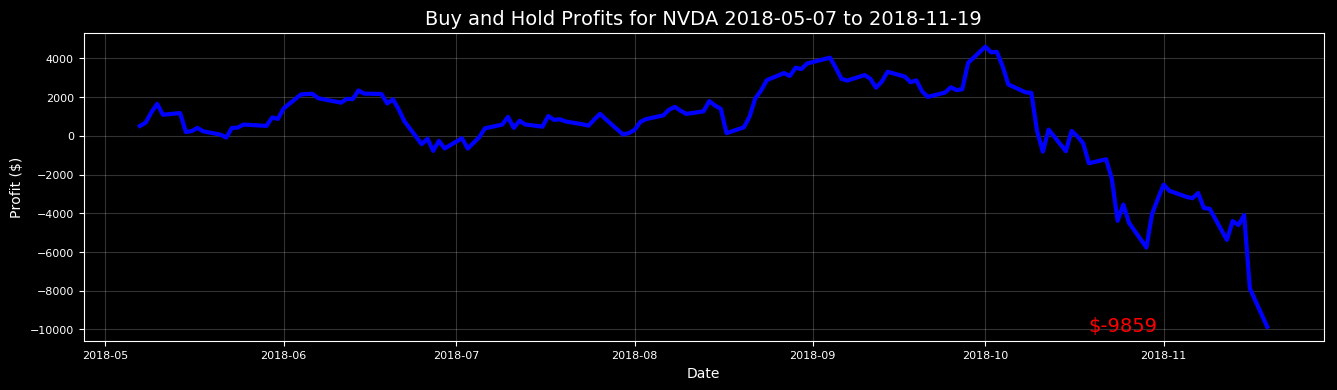

In [18]:
nvda.buy_and_hold(start_date='2018-05-06', end_date=yday, nshares=100)

In [ ]:
# # time series components 
# * trend - long term trend for inference
# * seasonal - seasonality i.e. holiday / winter for hot drinks, summer more ice-cream for sales
# * cyclic
# * random - irregular, errors, noises

nvda.test_stationarity() #adjclose['RTN'])#, 22

### Augmented Dickery Fuller (ADF) Test - Null Hypothesis (HO)

Null Hypothesis if p > 0.05 indicates data is non-stationary

Alternative Hypothesis if p < 0.05 indicates data is stationary


p-value : 2.255685e-10 is less than 0.05 indicates that it is stationary 
when using rolling statistic for one year period  - 263 days

lags used is : 0.032

Expanding is higher than the actual
Rolling std is pretty low
Others do follow the trend pretty well
Rolling Exponentially weighted mean seem to be following the trend pretty well


####  There are many ways to make time stationary
1. using log based differencing
    by log the data and then log - moving (rolling data) mean or std
    
2. using differencing or order differency  ( Yt = Yt - 1 )
3. using shift (Yt = Yt - Yt.shift() )

But since this share is stionary - so no need to do anything further

In [ ]:
# yearly
nvda.decompose_timeseries() #self, stats='Adj. Close', freq=263):

In [ ]:
# montly
nvda.decompose_timeseries(stats='Adj. Close', freq=22) #, model='multiplicative')

show upward trends

shows there is a pattern or seaonality involved

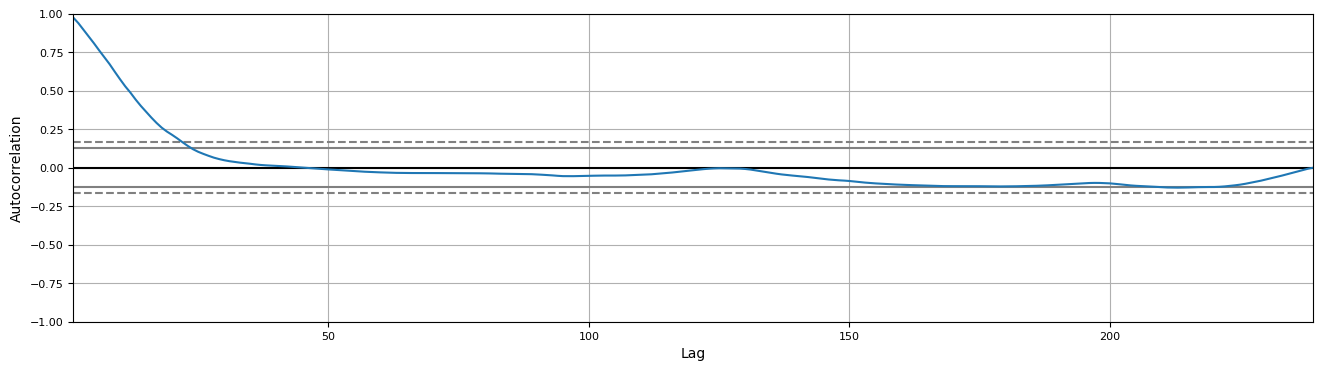

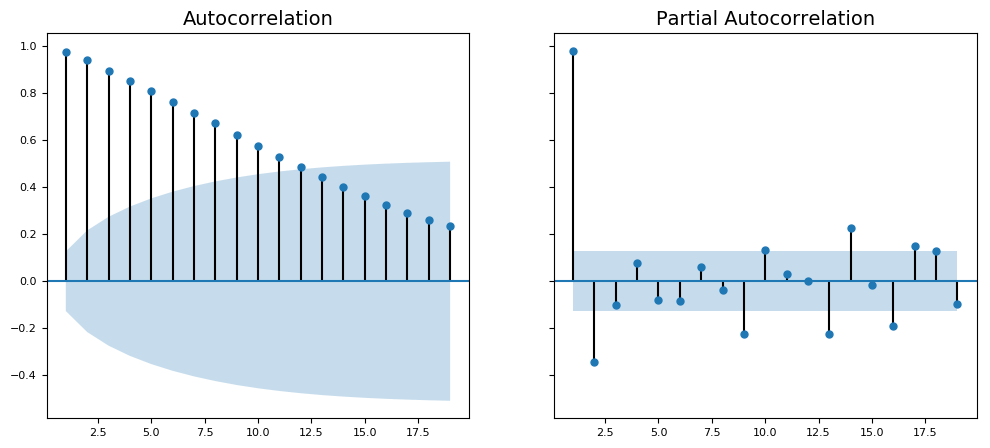

ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1401.9618483920608
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3350      0.026     12.668      0.000       0.283       0.387
ma.S.L12      -0.8463      0.048    -17.472      0.000      -0.941      -0.751
sigma2        40.7485      1.576     25.850      0.000      37.659      43.838


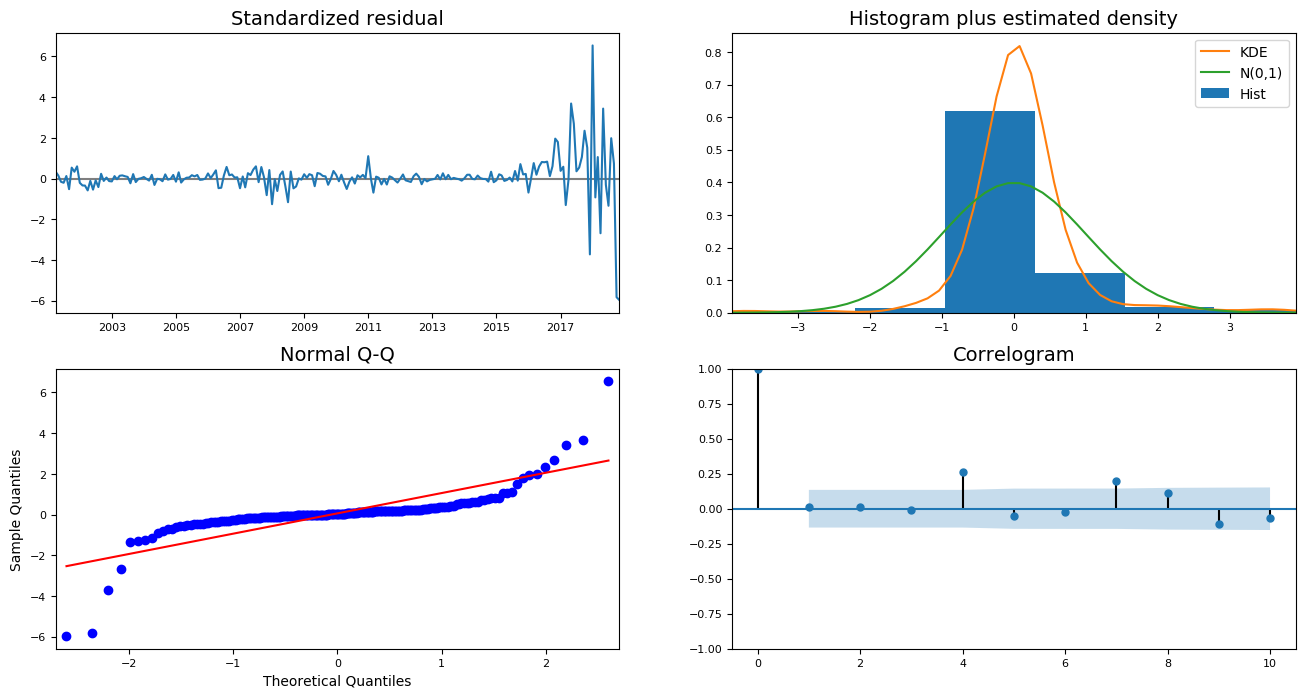

starting: 1999, ending: 2018, no of year for training: 2014
2014-1-1
prediction confident interval

            lower Adj. Close  upper Adj. Close
2014-01-01          2.429139         27.485302
2014-02-01          2.759107         27.814197


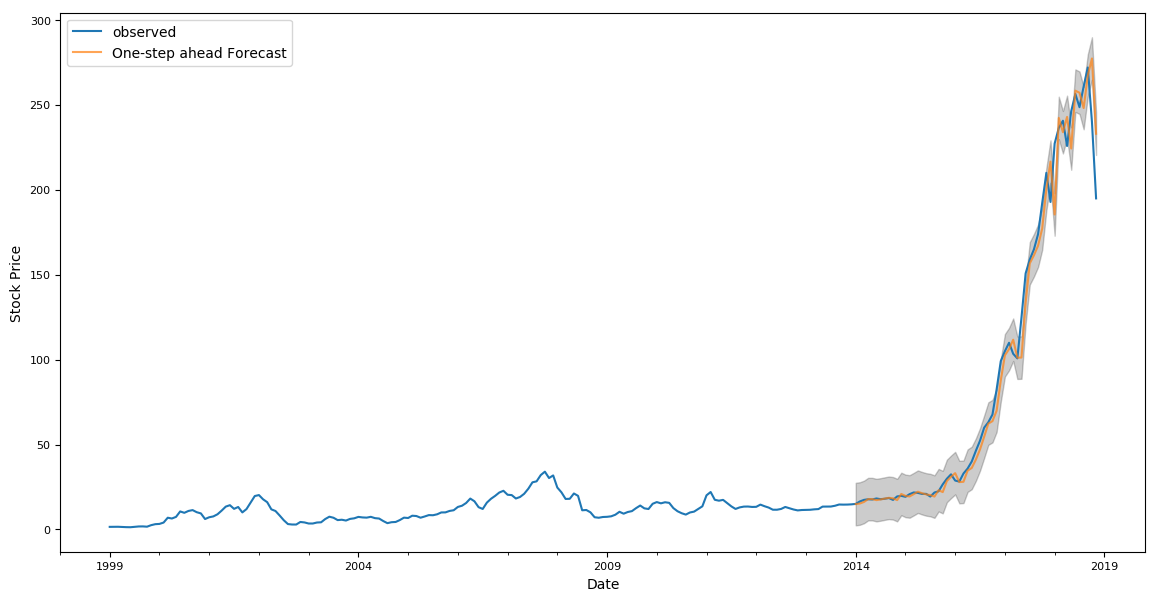

The Mean Squared Error of our forecasts is 136.73
The Root Mean Squared Error of our forecasts is 11.69
prediction confident interval

            lower Adj. Close  upper Adj. Close
2018-12-01        169.803018         194.83196
2019-01-01        167.238104         208.98702


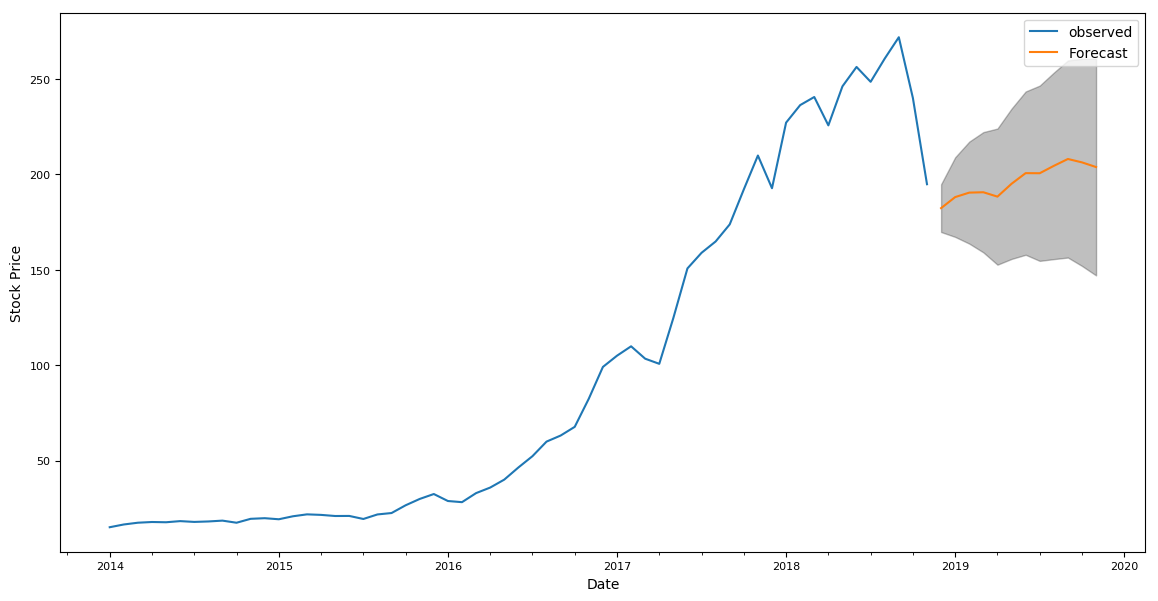

In [25]:

# The line plot is showing the observed values compared to the rolling forecast predictions. 
# Overall, our forecasts align with the true values very well, 
# Showing an upward trend starts from the beginning of the year.

#(R)MSE, the smaller value indicates how closly the prediction is to actual values
results, pred_uc = nvda.sarima_model() #stats='Adj. Close', freq='MS'

In [39]:
results = pred_uc.prediction_results
#results.results.forecasts

In [38]:
pred_ci = pred_uc.conf_int()
pred_ci.head()

,lower Adj. Close,upper Adj. Close
2018-12-01,169.803018,194.831960
2019-01-01,167.238104,208.987020
2019-02-01,163.714955,217.189117
2019-03-01,159.120222,222.174573
2019-04-01,152.670945,224.030713


In [40]:
amzn = shares('amzn')

AMZN Shares Initialized. Data covers 1998-01-02 to 2018-11-20.


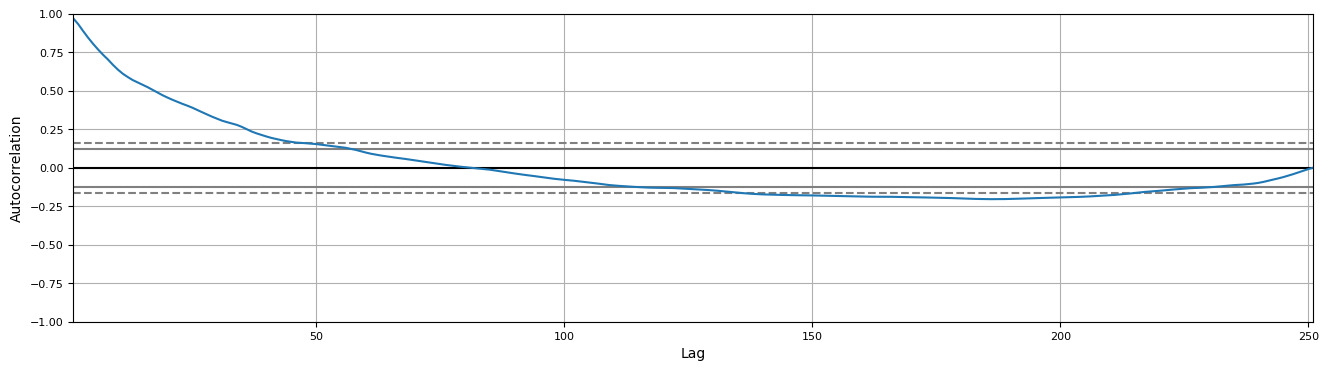

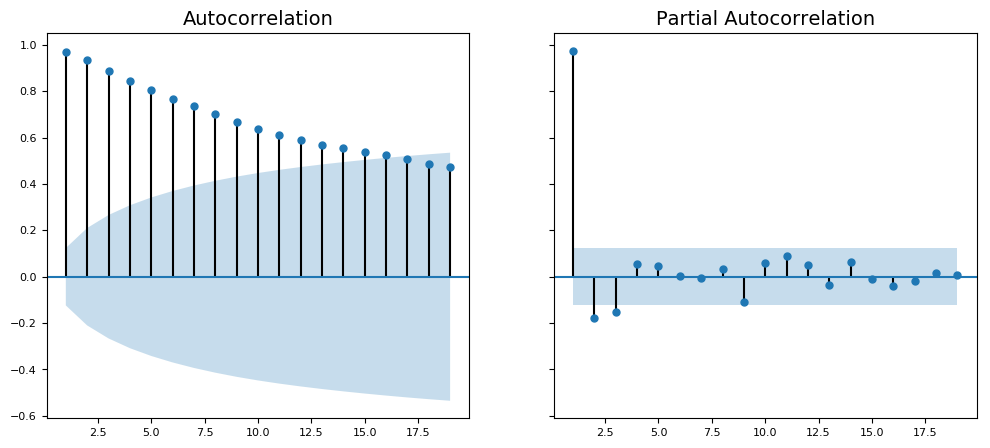

ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:2177.355319802545
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4146      0.036     11.451      0.000       0.344       0.486
ar.S.L12      -0.5451      0.062     -8.773      0.000      -0.667      -0.423
ma.S.L12      -0.6707      0.047    -14.122      0.000      -0.764      -0.578
sigma2       914.4698     34.150     26.778      0.000     847.537     981.402


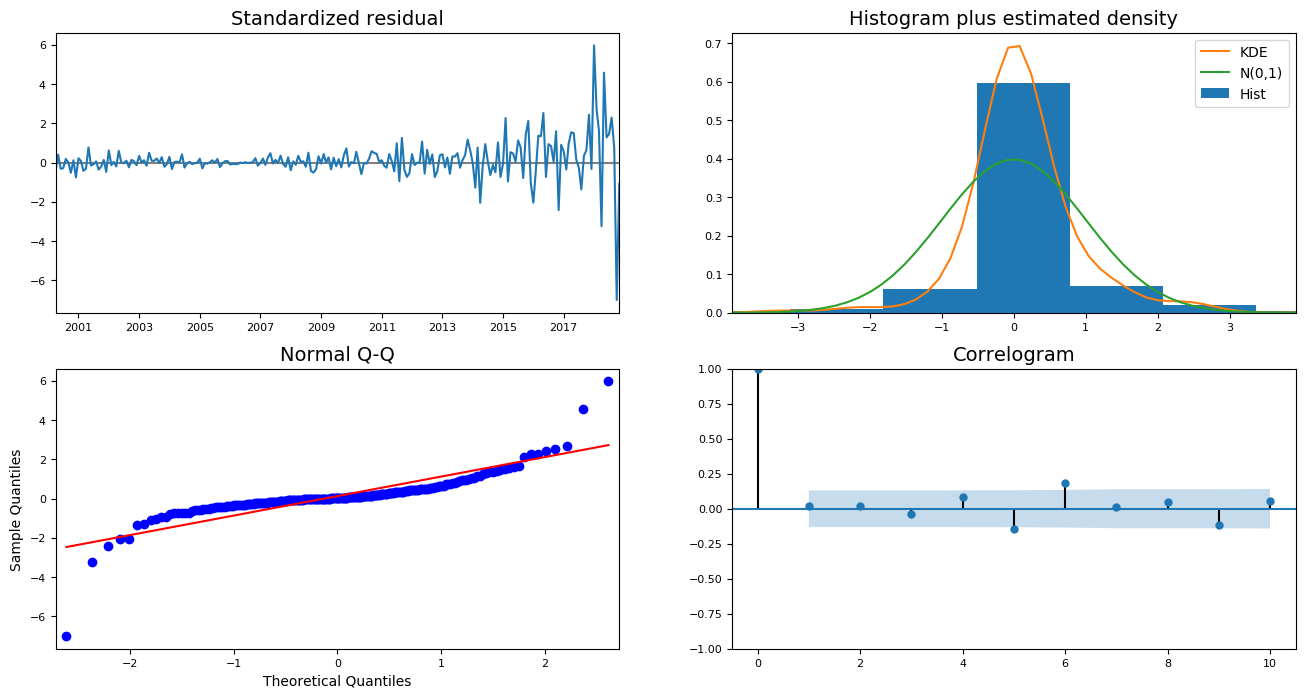

starting: 1998, ending: 2018, no of year for training: 2014
2014-1-1
prediction confident interval

            lower Adj. Close  upper Adj. Close
2014-01-01        336.188142        454.727965
2014-02-01        333.716557        452.256208


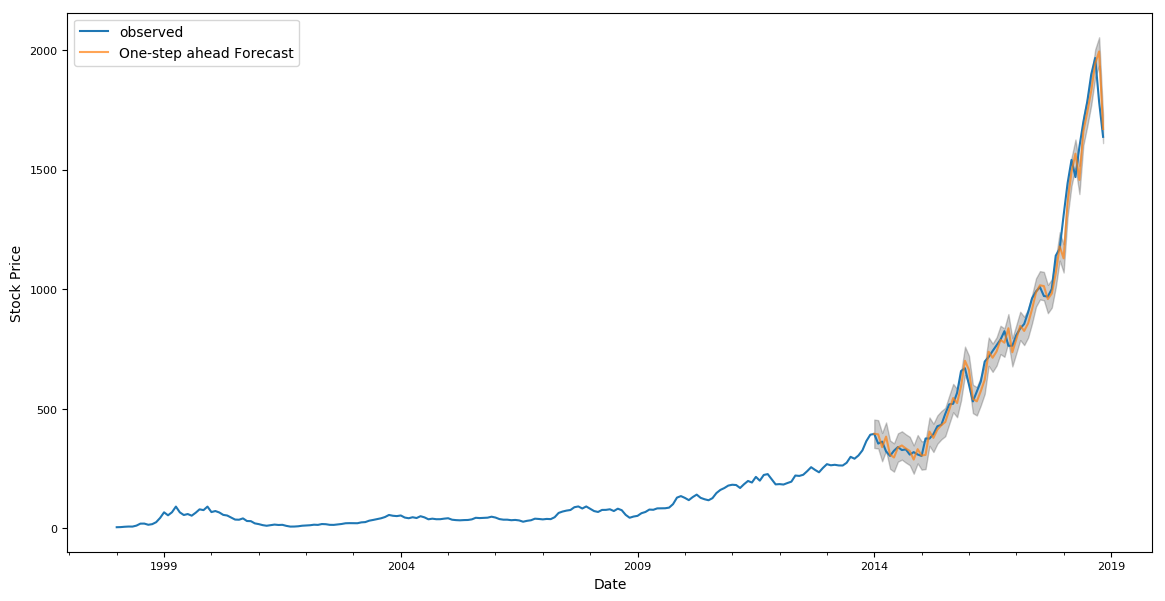

The Mean Squared Error of our forecasts is 3149.39
The Root Mean Squared Error of our forecasts is 56.12
prediction confident interval

            lower Adj. Close  upper Adj. Close
2018-12-01       1562.973328       1681.512749
2019-01-01       1489.175460       1694.530496


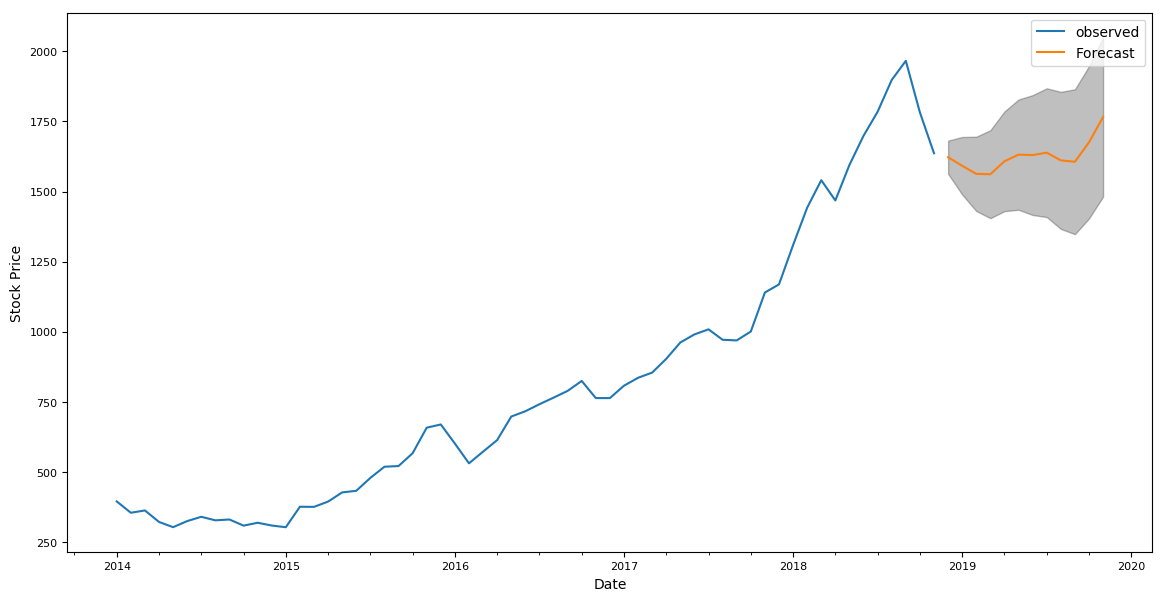

In [41]:
results, pred_uc = amzn.sarima_model() #stats='Adj. Close', freq='MS'

In [42]:
baba = shares('BABA')

BABA Shares Initialized. Data covers 2014-09-19 to 2018-11-20.


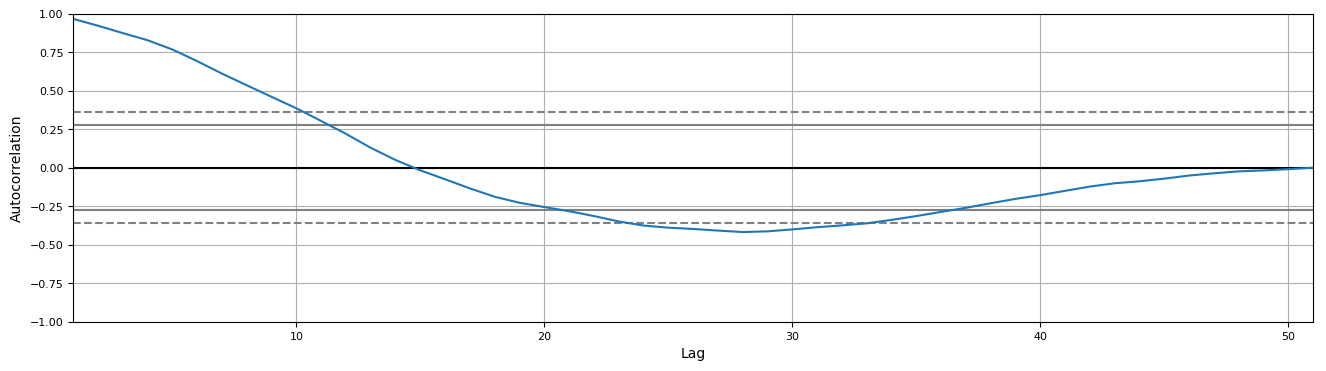

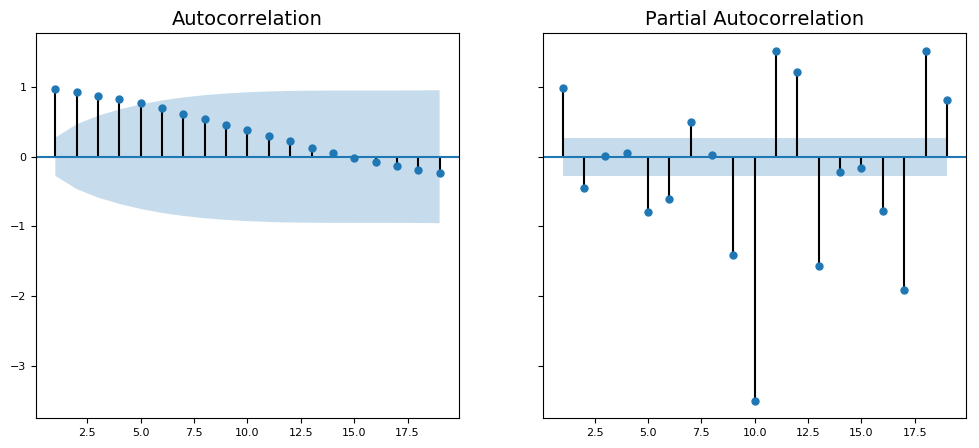

ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:196.6857277585613
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2823      0.208      1.360      0.174      -0.124       0.689
ar.S.L12      -0.2575      0.783     -0.329      0.742      -1.792       1.278
ma.S.L12      -0.2132      0.977     -0.218      0.827      -2.129       1.702
sigma2       149.1060     60.252      2.475      0.013      31.014     267.198


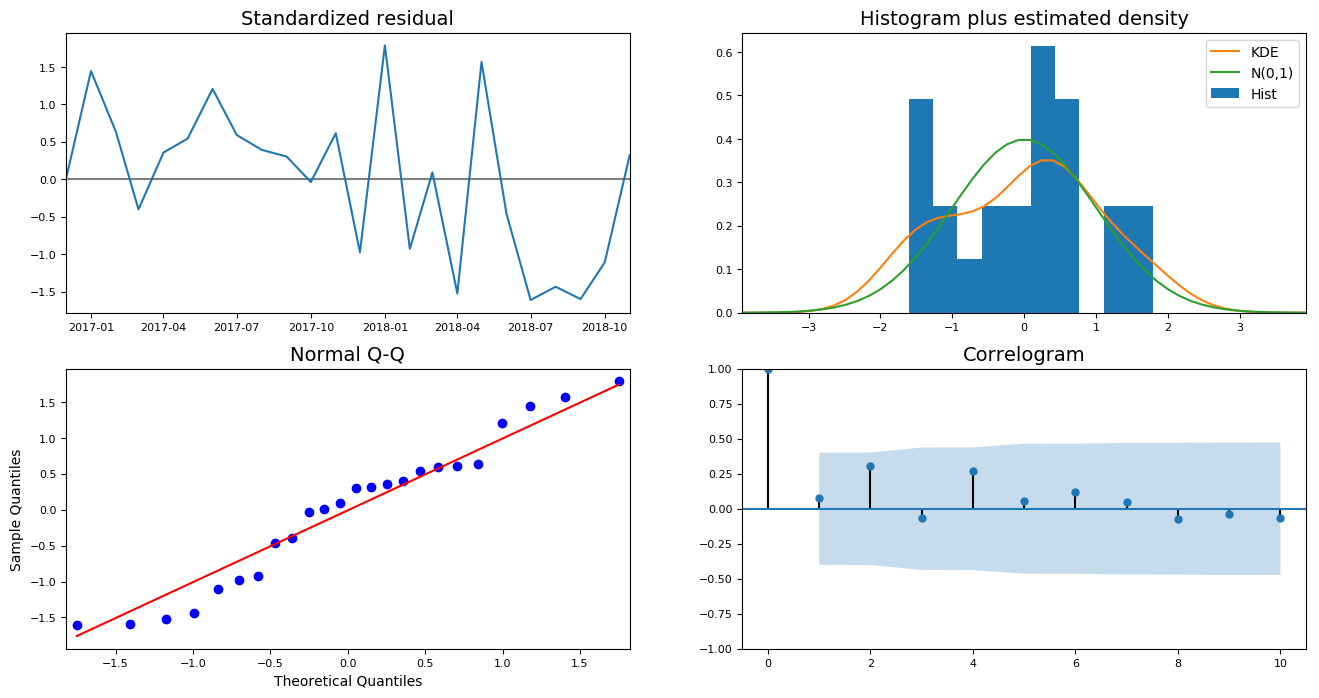

starting: 2014, ending: 2018, no of year for training: 2017
2017-1-1
prediction confident interval

            lower Adj. Close  upper Adj. Close
2017-01-01         54.670839        103.608556
2017-02-01         69.709188        118.646074


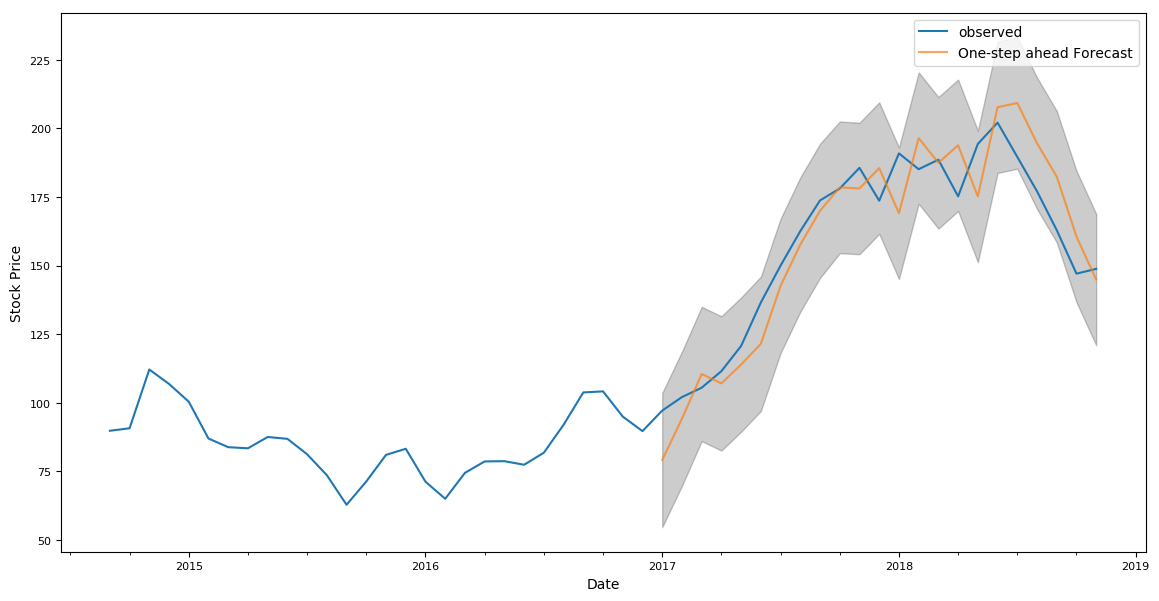

The Mean Squared Error of our forecasts is 157.3
The Root Mean Squared Error of our forecasts is 12.54
prediction confident interval

            lower Adj. Close  upper Adj. Close
2018-12-01        117.790125        165.658124
2019-01-01        113.613905        191.452903


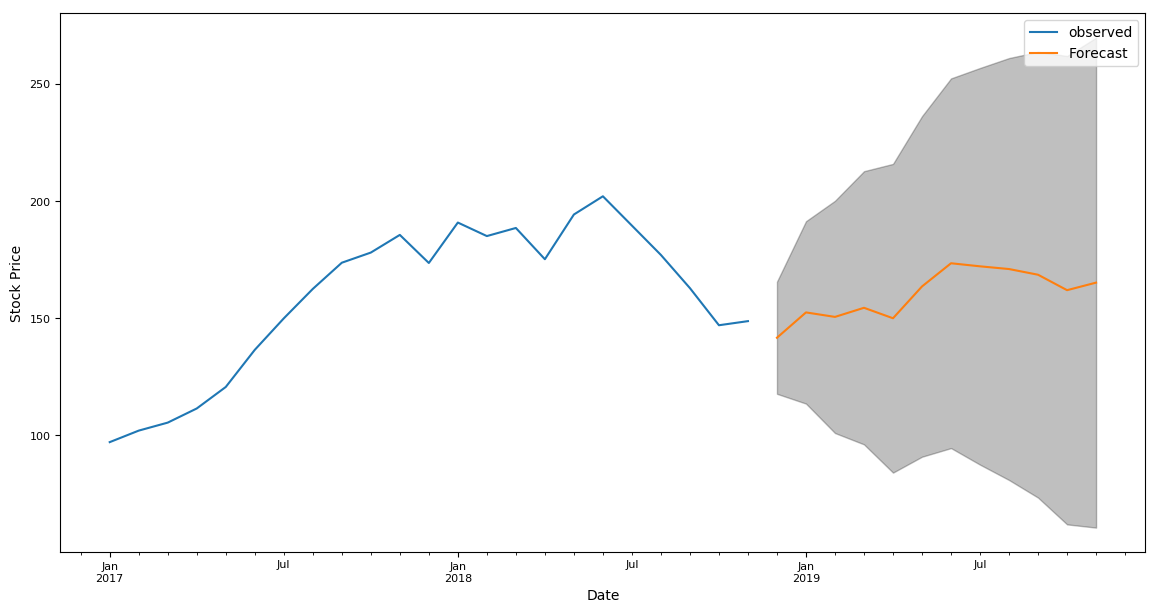

In [43]:
results, pred_uc = baba.sarima_model()